### Get a Role

In [4]:
# Dataset is from kaggle: https://www.kaggle.com/pranavraikokte/covid19-image-dataset. Upload it on your S3 bucket

import sagemaker
from sagemaker import get_execution_role
import boto3
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt

role = get_execution_role()
print(role)

# Fill your bucket name
sess = sagemaker.Session()
BUCKET_NAME = "fnandito-covid-analysis"
prefix = 'lstFile'

print('using bucket %s'%BUCKET_NAME)

arn:aws:iam::930652504693:role/sagemaker-soln-fdml--us-east-1-nb-role
using bucket fnandito-covid-analysis


### Download Images from S3

In [5]:
trainFileArr = []
testFileArr = []

In [6]:
def isCovid(DirName):
    if DirName.find("Covid") != -1:
        return 1
    else:
        return 0

In [7]:
def isPneumonia(DirName):
    if DirName.find("Pneumonia") != -1:
        return 1
    else:
        return 0

In [8]:
def GetNameDirFromS3(bucketName, remoteDirectoryName):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucketName)
    for obj in bucket.objects.filter(Prefix = remoteDirectoryName):
        #if not os.path.exists(os.path.dirname(obj.key)):
        #    os.makedirs(os.path.dirname(obj.key))
        #bucket.download_file(obj.key, obj.key) # save to same path
        FileName =  obj.key.split("/")
        Label = FileName[2]
        Fn = Label + "/" + FileName[3]
        if remoteDirectoryName == "Covid19-dataset/train/":
            trainFileArr.append({'Name': Fn ,'LabelCovid': isCovid(Label), 'LabelPneumonia': isPneumonia(Label)})
        else:
            testFileArr.append({'Name': Fn ,'LabelCovid': isCovid(Label), 'LabelPneumonia': isPneumonia(Label)})

In [9]:
GetNameDirFromS3(BUCKET_NAME, "Covid19-dataset/train/")
GetNameDirFromS3(BUCKET_NAME, "Covid19-dataset/test/")

In [10]:
trainFile = pd.DataFrame(trainFileArr, columns=['Name','LabelCovid','LabelPneumonia'])
testFile = pd.DataFrame(testFileArr, columns=['Name','LabelCovid','LabelPneumonia'])

In [11]:
trainFile

,Name,LabelCovid,LabelPneumonia
0,Covid/01.jpeg,1,0
1,Covid/010.png,1,0
2,Covid/012.jpeg,1,0
3,Covid/015.jpg,1,0
4,Covid/019.png,1,0
...,...,...,...
246,Viral Pneumonia/084.jpeg,0,1
247,Viral Pneumonia/09.jpeg,0,1
248,Viral Pneumonia/094.jpeg,0,1
249,Viral Pneumonia/095.jpeg,0,1


### Data Train Exploration

In [12]:
# 0 = Normal
# 1 = Covid
# 2 = pneumonia

CovidLabel = trainFile.groupby('LabelCovid').count()
PneumoniaLabel = trainFile.groupby('LabelPneumonia').count()
TotalData = CovidLabel["Name"][0] + CovidLabel["Name"][1]
TotalTrainCovid = CovidLabel["Name"][1]
TotalTrainPneumonia = PneumoniaLabel["Name"][1]
TotalTrainNormal = TotalData - TotalTrainCovid - TotalTrainPneumonia
print("Total Train Data : ",TotalData)
print("Total Train Covid Data : ",TotalTrainCovid)
print("Total Train Pneumonia Data : ",TotalTrainPneumonia)
print("Total Train Normal Data : ",TotalTrainNormal)

Total Train Data :  251
Total Train Covid Data :  111
Total Train Pneumonia Data :  70
Total Train Normal Data :  70


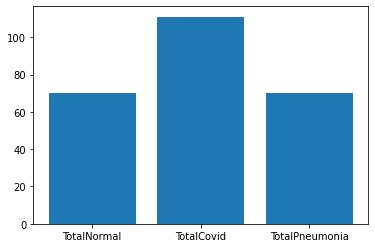

In [13]:
AxisYBar = [TotalTrainNormal, TotalTrainCovid, TotalTrainPneumonia]
AxisXBar = ["TotalNormal", "TotalCovid", "TotalPneumonia"]

plt.bar(AxisXBar, AxisYBar)
plt.show()

### Create LST File

In [14]:
with open('TrainImageList.lst', 'w') as fp:
    for index, df in trainFile.iterrows():
        fp.write(str(index) + '\t')
        fp.write(str(df["LabelCovid"]) + '\t')
        fp.write(str(df["LabelPneumonia"]) + '\t')
        fp.write(df["Name"])
        fp.write('\n')
    fp.close()

In [15]:
with open('TestImageList.lst', 'w') as fp:
    for index, df in testFile.iterrows():
        fp.write(str(index) + '\t')
        fp.write(str(df["LabelCovid"]) + '\t')
        fp.write(str(df["LabelPneumonia"]) + '\t')
        fp.write(df["Name"])
        fp.write('\n')
    fp.close()

## Upload LST file to S3

In [16]:
s3train_lst = 's3://{}/{}/train_lst/'.format(BUCKET_NAME, prefix)
s3validation_lst = 's3://{}/{}/validation_lst/'.format(BUCKET_NAME, prefix)

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp TrainImageList.lst $s3train_lst --quiet
!aws s3 cp TestImageList.lst $s3validation_lst --quiet

## Create estimator

In [17]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


475088953585.dkr.ecr.ap-southeast-1.amazonaws.com/image-classification:1


In [18]:
s3_output_location = 's3://{}/output'.format(BUCKET_NAME)
multilabel_ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Set the data Train and test

In [19]:
s3train = "s3://{}/{}/train/".format(BUCKET_NAME, "Covid19-dataset")
s3validation = "s3://{}/{}/test/".format(BUCKET_NAME, "Covid19-dataset")

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
                             
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data, 'train_lst': train_data_lst, 
                 'validation_lst': validation_data_lst}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Set hyperparameters

In [20]:
multilabel_ic.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=2,
                             mini_batch_size=16,
                             resize=256,
                             epochs=5,
                             learning_rate=0.001,
                             num_training_samples=2500,
                             use_weighted_loss=1,
                             augmentation_type = 'crop_color_transform',
                             precision_dtype='float32',
                             multi_label=1)

### Train the model

In [21]:
multilabel_ic.fit(inputs=data_channels, logs=True)

2021-04-12 09:52:40 Starting - Starting the training job...
2021-04-12 09:52:42 Starting - Launching requested ML instancesProfilerReport-1618221160: InProgress
......
2021-04-12 09:53:57 Starting - Preparing the instances for training............
2021-04-12 09:56:07 Downloading - Downloading input data
2021-04-12 09:56:07 Training - Downloading the training image...
2021-04-12 09:56:39 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[04/12/2021 09:56:44 INFO 139793416881984] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[04/12/2021 09:56:44 IN

### Create Inference

In [22]:
ic_classifier = multilabel_ic.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

---------------!

In [23]:
ic_classifier

### Create Endpoint Configuration

In [24]:
sage = boto3.Session().client(service_name='sagemaker') 

# Fill your own Endpoint config name, copy the name of your model name on your SageMaker Console, in Inference -> Model.
endpoint_config_name = "COVID19-ML-Config"
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':"image-classification-2021-04-09-03-18-22-970",
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

ClientError: An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:ap-southeast-1:930652504693:endpoint-config/covid19-ml-config".

### Create Endpoint

In [25]:
endpoint_name = "COVID19-ML-Endpoint"

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
sagemaker = boto3.client(service_name='sagemaker')
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:ap-southeast-1:930652504693:endpoint/covid19-ml-endpoint".

### Check Endpoint Status

In [ ]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

### Download Dataset from S3 to local

In [26]:
def DownloadfromS3(bucketName, remoteDirectoryName):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucketName)
    for obj in bucket.objects.filter(Prefix = remoteDirectoryName):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key) # save to same path

In [27]:
DownloadfromS3(BUCKET_NAME, 'Covid19-dataset/')

### Evaluate

In [464]:
import json

file_name_covid = './Covid19-dataset/test/Covid/0100.jpeg'
file_name_normal = './Covid19-dataset/test/Normal/0101.jpeg'
file_name_pneumonia = './Covid19-dataset/test/Viral Pneumonia/0101.jpeg'

with open(file_name_covid, 'rb') as image:
    f_covid = image.read()
    
with open(file_name_normal, 'rb') as image:
    f_normal = image.read()
    
with open(file_name_pneumonia, 'rb') as image:
    f_pneumonia = image.read()

In [465]:
import numpy as np

runtime = boto3.Session().client(service_name='runtime.sagemaker')
response_covid = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=f_covid)

response_normal = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=f_normal)

response_pneumonia = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=f_pneumonia)

result_covid = response_covid['Body'].read()
result_normal = response_normal['Body'].read()
result_pneumonia = response_pneumonia['Body'].read()
# result will be in json format and convert it to ndarray
result_covid = json.loads(result_covid)
result_normal = json.loads(result_normal)
result_pneumonia = json.loads(result_pneumonia)
# the result will output the probabilities for all classes

# find the class with maximum probability and print the class index
index_covid = np.argmax(result_covid)
index_normal = np.argmax(result_normal)
index_pneumonia = np.argmax(result_pneumonia)

In [466]:
print(result_covid)
print(result_normal)
print(result_pneumonia)

[0.999180018901825, 0.0001191550909425132]
[0.0001682815345702693, 0.00040817074477672577]
[0.0004312075034249574, 0.8659377098083496]


### Roadmap - Tune Hyperparameter

In [416]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter

my_tuner = HyperparameterTuner(estimator=multilabel_ic,  # previously-configured Estimator object
                               objective_metric_name='validation-accuracy',
                               hyperparameter_ranges={'learning-rate': ContinuousParameter(0.05, 0.06)},
                               metric_definitions=[{'Name': 'validation-accuracy', 'Regex': 'validation-accuracy=(\d\.\d+)'}],
                               max_jobs=100,
                               max_parallel_jobs=10)

# Start hyperparameter tuning job
my_tuner.fit(inputs=data_channels, logs=True)

# Deploy best model
my_predictor = my_tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateHyperParameterTuningJob operation: The account-level service limit 'ml.p2.xlarge for training job usage' is 1 Instances, with current utilization of 0 Instances and a request delta of 10 Instances. Please contact AWS support to request an increase for this limit.

In [ ]:
# Make a prediction against the SageMaker endpoint
response = my_predictor.predict(validation_data)